In [83]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tensorflow import keras 
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from sklearn.preprocessing import MinMaxScaler

In [31]:
def load_zillow(): 
    df = pd.read_csv("../data/zillow_merged.csv")
    df["datetime"] = pd.to_datetime(df["date"])
    df = df.drop(columns = ["indicator_id", "region_id", "date", "indicator", "category"])
    df = df[df["region_type"] == 'zip']
    df = df.drop(columns = ["region_type"])
    
    def zip_split(loc, index = 0): 
        return loc.split(";")[index]


    df["zip"] = df["region"].apply(zip_split)
    df = df.drop(columns = "region")
    return df

zillow = load_zillow()

In [45]:
def plot_time_series(zip_code = '98847', plot = plt): 
    region_frame = zillow[zillow["zip"] == zip_code]
    xs = region_frame["datetime"]
    ys = region_frame["value"]
    
 
    plot.set_title(f"Home values in {zip_code}")
    plot.set_xlabel("Time")
    plot.set_ylabel("Value")
    plot.plot(xs, ys, color = 'black')


(43,)

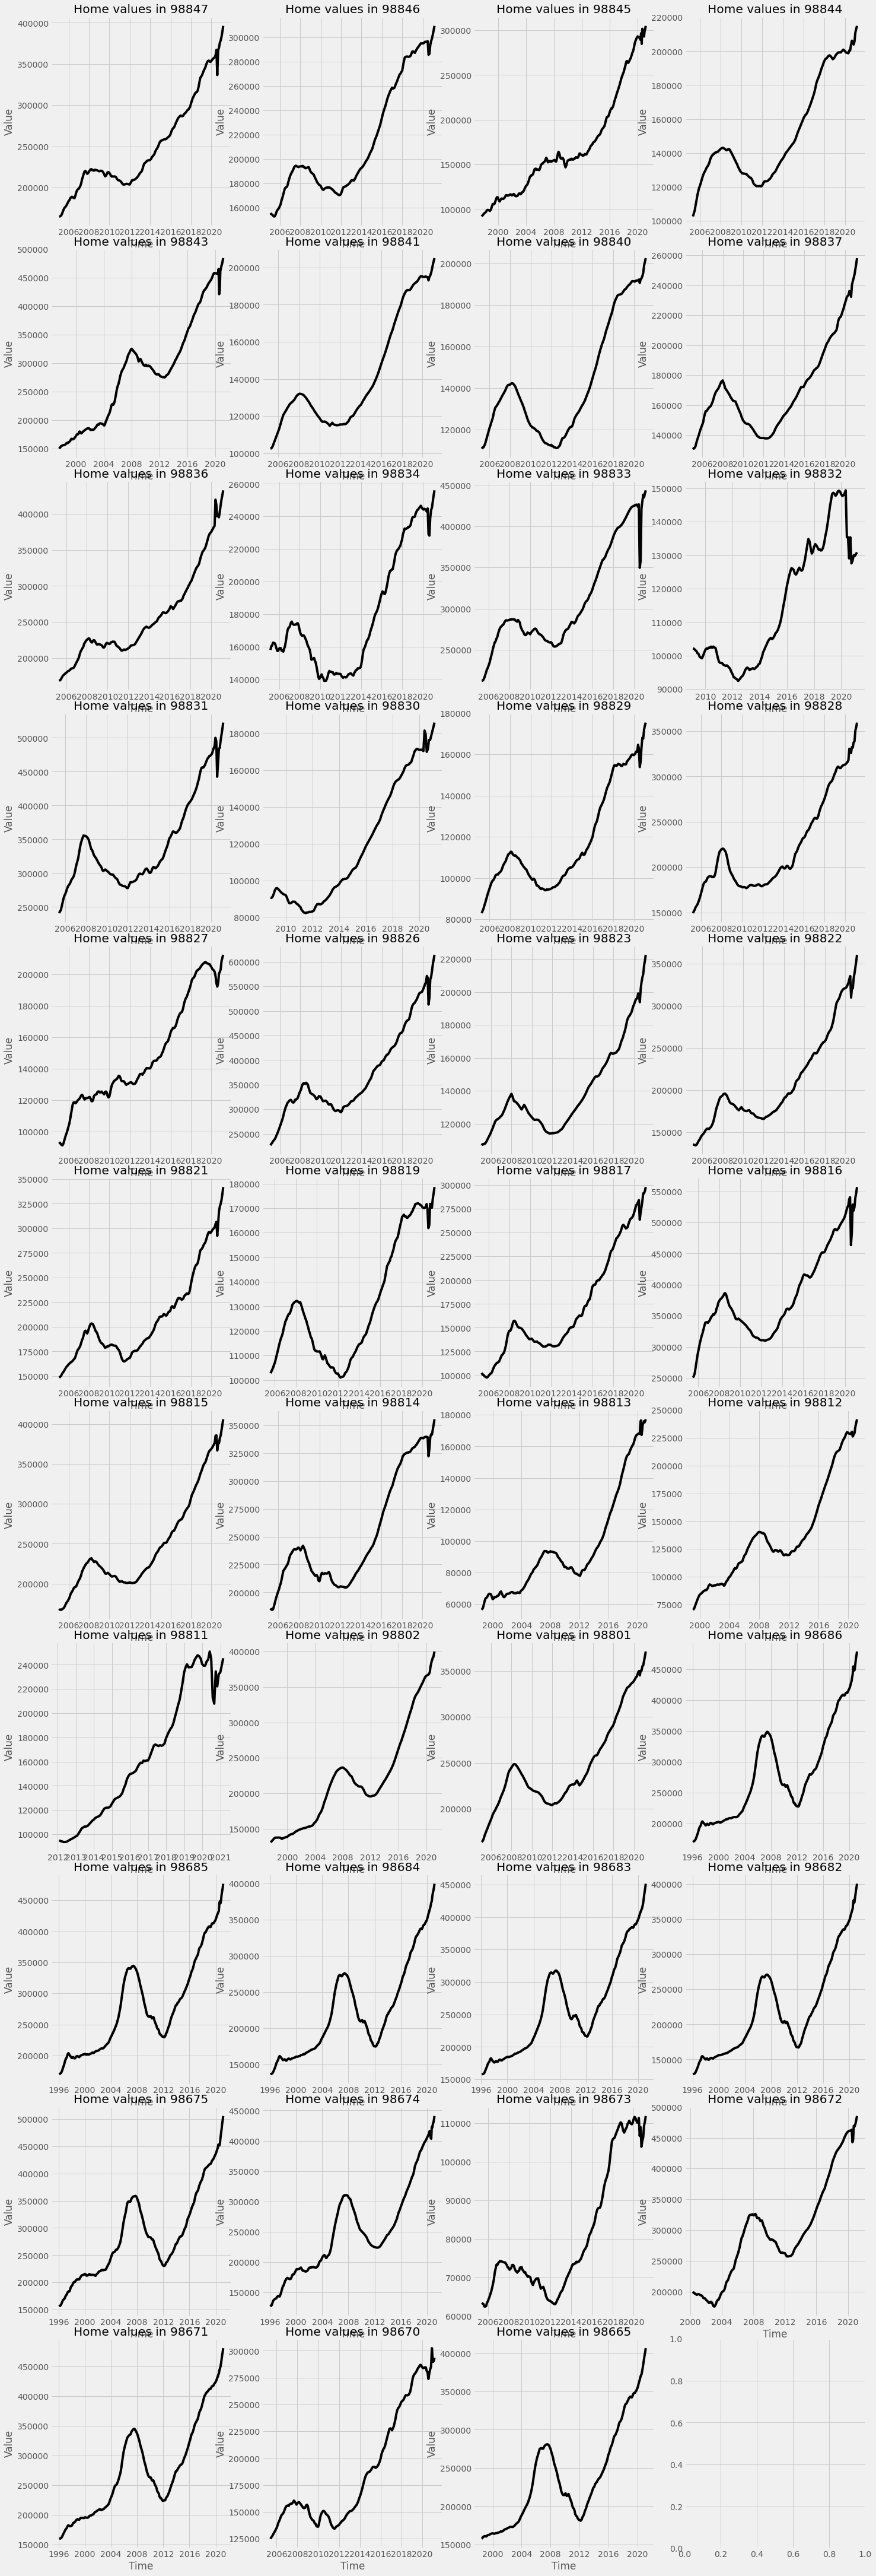

In [155]:
plt.rcParams["figure.figsize"] = [20, 60]
plt.style.use("fivethirtyeight")

fig, axes = plt.subplots(11, 4)
fig.tight_layout()


for ax, loc in zip(axes.flatten()[:], zillow.zip.unique()): 
    plot_time_series(zip_code = loc, plot = ax)


zillow.zip.unique().shape

In [126]:
wentachee = zillow[zillow.zip == '98847']

In [127]:
wentachee.isna().sum()
wentachee = wentachee.drop(columns = ["datetime", "zip"])

In [128]:
##Splitting into Training and Testing Data 
train_size = int(0.8*len(wentachee))

train_wentachee = wentachee[::-1][:train_size].reset_index()
test_wentachee = wentachee[::-1][train_size:].reset_index()

In [129]:
###Reshape input into 3 Dimensions
    
train_wentachee = train_wentachee.drop("index", axis = 1)
test_wentachee = test_wentachee.drop("index", axis = 1)

In [130]:
train = train_wentachee.to_numpy()
test = test_wentachee.to_numpy()

In [131]:
scaler = MinMaxScaler().fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [132]:
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)

x_train, y_train = create_dataset(train, 8)
x_test, y_test = create_dataset(test, 8)

In [133]:
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
                input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model



gru = create_gru(64)

In [134]:
gru.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 8, 64)             12864     
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 64)             0         
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


In [135]:
gru.fit(x_train, y_train, epochs = 100)

Epoch 1/100
5/5 [==============================] - 0s 7ms/step - loss: 0.2011
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0295
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0353
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0139
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0072
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 11/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 12/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 13/100
5/5 [==============================] - 0s 5ms/st

In [213]:
predicted = scaler.inverse_transform(gru.predict(x_test))

31
31


0.6899763524252818

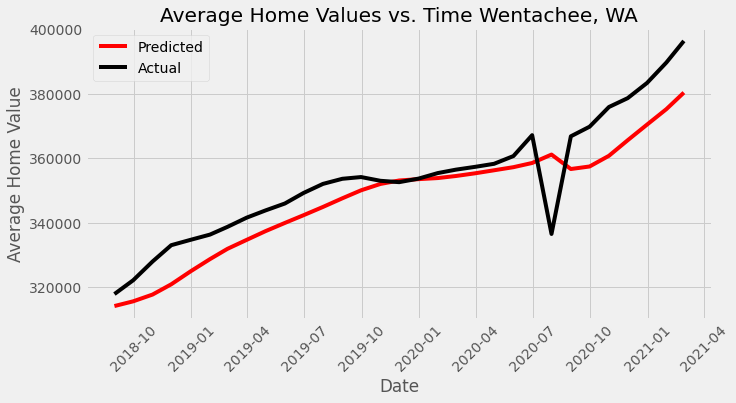

In [214]:
region_frame = zillow[zillow["zip"] == '98847']
plt.rcParams["figure.figsize"] = [10, 5]
xs = region_frame["datetime"][::-1][train_size+8:]
plt.plot(xs, predicted, color = "red")
plt.plot(xs, scaler.inverse_transform(y_test), color = "black")
plt.xlabel("Date")
plt.ylabel("Average Home Value")
plt.xticks(rotation = 45)
plt.title("Average Home Values vs. Time Wentachee, WA")
plt.legend(["Predicted", "Actual"])
plt.savefig("../plots/wentachee_1d_gru.png", bbox_inches = "tight")

print(len(xs))
print(len(predicted))
from sklearn.metrics import r2_score

r2_score(predicted, scaler.inverse_transform(y_test))

In [175]:
region_frame.drop("zip", axis = 1)

,value,datetime
0,396263.0,2021-02-28
1,389595.0,2021-01-31
2,383270.0,2020-12-31
3,378566.0,2020-11-30
4,375825.0,2020-10-31
...,...,...
189,169868.0,2005-05-31
190,167105.0,2005-04-30
191,165721.0,2005-03-31
192,164998.0,2005-02-28


In [182]:
long_term_wash = pd.read_csv("../data/washington.csv", index_col = 0).transpose()
long_term_wash

,loan_amount_000s,population,minority_population,hud_median_family_income
2014,276.019697,5325.572092,24.663210,75150.266877
2015,296.667876,5344.553204,24.600485,76803.155761
2016,315.794318,5332.407140,24.617906,76418.259577
2017,341.408179,5579.166888,26.248856,79440.841106


<AxesSubplot:>

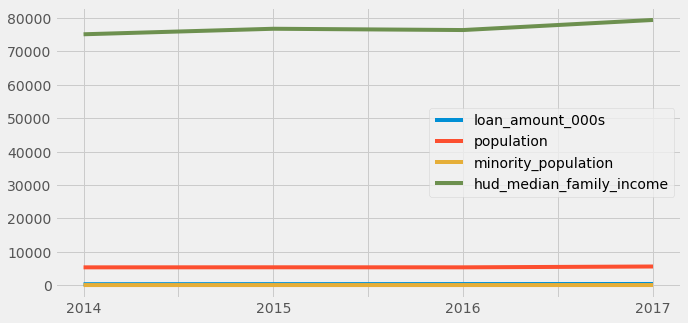

In [187]:
long_term_wash.plot()

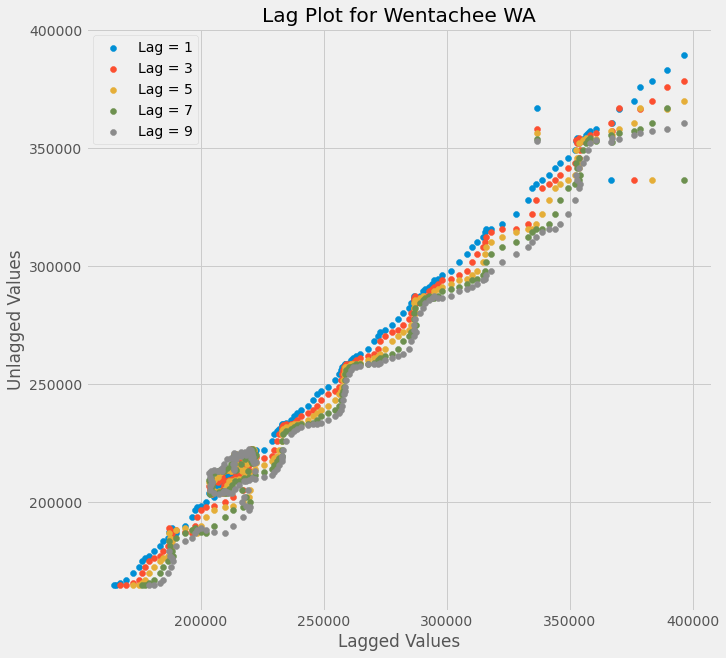

In [202]:

plt.rcParams["figure.figsize"] = [10, 10]

for i in range(1, 10, 2): 
    y1 = region_frame[::-1]["value"].iloc[i:]
    y2 = region_frame[::-1]["value"].iloc[:-i]
    plt.scatter(y1, y2)

plt.title("Lag Plot for Wentachee WA")
plt.xlabel("Lagged Values")
plt.ylabel("Unlagged Values")
plt.legend(["Lag = 1", "Lag = 3", "Lag = 5", "Lag = 7", "Lag = 9"])
plt.savefig("../plots/wentachee_lag.png")

In [211]:
def create_lstm(): 
    model = Sequential()
    model.add(LSTM(50, input_shape = (8, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model 


lstm = create_lstm()
lstm.fit(x_train, y_train, epochs = 100)

Epoch 1/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1930
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0929
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0267
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0082
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0072
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 11/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 12/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 13/100
5/5 [==============================] - 0s 4ms/st

31
31


0.701508639444755

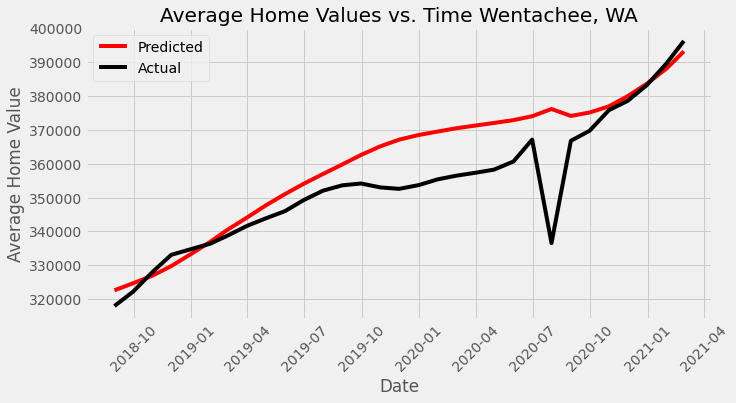

In [215]:
predicted = scaler.inverse_transform(lstm.predict(x_test))
plt.rcParams["figure.figsize"] = [10, 5]
xs = region_frame["datetime"][::-1][train_size+8:]
plt.plot(xs, predicted, color = "red")
plt.plot(xs, scaler.inverse_transform(y_test), color = "black")
plt.xlabel("Date")
plt.ylabel("Average Home Value")
plt.xticks(rotation = 45)
plt.title("Average Home Values vs. Time Wentachee, WA")
plt.legend(["Predicted", "Actual"])
plt.savefig("../plots/wentachee_1d_lstm.png", bbox_inches = "tight")

print(len(xs))
print(len(predicted))
r2_score(predicted, scaler.inverse_transform(y_test))